In [1]:
import cPickle as pkl
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
import numpy as np

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

<font color='red'>
# TODO: how does mRNA transcript abundance influence cell-level synthesis rates?

There is a connection between initiation probability and abundance, so multiplying transcript-level speeds by abundance will lead to a "non-linear" effect.
</font>

## Table of contents

[1. Model for protein speeds ("tic toc" TRSL output)](#1.)

[1.0 Get data](#1.0)

[1.1 Ribosome speed](#1.1)

[1.2 Duration post initiation](#1.2)

[1.3 Combination of the previous two models](#1.3)

<a id='1.'></a>
## 1. Model for protein speeds ("tic toc" TRSL output)

General form:

$$v = f(l, t)$$

where $v = \frac{\Delta \mathrm{abundance}}{\Delta t}$: ribosome speed on the gene

$l$: gene length in nts (or codons) (a bit counterintuitive but worth a try)

$t$: adaptation index (tAI or cAI)

<a id='1.0'></a>
### 1.0 Get data

Ribosome speeds:

Lengths:

In [2]:
orf_genomic_dict = pkl.load(open("../../parameters/orf_coding.p"))
len(orf_genomic_dict)

6713

In [3]:
orf_lengths = {prot: len(orf_genomic_dict[prot]) for prot in orf_genomic_dict}

In [4]:
ribo_speeds = pkl.load(open("../../parameters/tic_toc_speed_dict.p"))
len(ribo_speeds)

4475

tAIs:

In [5]:
tais = pkl.load(open("../../parameters/tAI_python_chu.p"))
len(tais)

6713

Total set intersection:

In [6]:
len(orf_lengths.viewkeys() & ribo_speeds.viewkeys() & tais.viewkeys())

4475

In [7]:
gene_tic_toc_dict = pkl.load(open("../../parameters/gene_tic_toc_dict.p"))

In [8]:
len(orf_lengths.viewkeys() & ribo_speeds.viewkeys() & tais.viewkeys() & gene_tic_toc_dict.viewkeys())

4475

So ribosome speeds are the limiting factor, as expected.

<a id='1.1'></a>
### 1.1 Ribosome speed

General form:

$$v = \beta_\mathrm{tAI} \cdot \mathrm{tAI} + \alpha_\mathrm{tAI}$$

First the univariate scatter plots:

In [9]:
from statsmodels.nonparametric.smoothers_lowess import lowess
def scatter_dicts(dict1, dict2, xaxislabel=None, yaxislabel=None, fontsize=None, alpha=0.2, xlog=True, ylog=True):
    plotkeys = dict1.viewkeys() & dict2.viewkeys() # set intersection
    print len(plotkeys)
    xs = [dict1[key] for key in plotkeys]
    ys = [dict2[key] for key in plotkeys] 

    fig =  plt.figure()                

    ax = fig.add_subplot(111)
    ax.grid(True, linestyle = '-')
    if xlog:
        ax.set_xscale('log')
    if ylog:
        ax.set_yscale('log')
    if xaxislabel:
        ax.set_xlabel(xaxislabel)
        if fontsize:
            ax.set_xlabel(xaxislabel, fontsize=fontsize)
            plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    if yaxislabel:
        ax.set_ylabel(yaxislabel)
        if fontsize:
            ax.set_ylabel(yaxislabel, fontsize=fontsize)
            plt.setp(ax.get_yticklabels(), fontsize=fontsize)

    scat = plt.scatter(xs, ys, color='b', alpha=alpha)
    scat.set_alpha(alpha)

    points = zip(xs, ys)
    sorted_points = sorted(points)
    new_xs = [point[0] for point in sorted_points]
    new_ys = [point[1] for point in sorted_points]
    ylowess = lowess(new_ys, new_xs, missing='raise', return_sorted=True)[:,1]
    
    plt.plot(new_xs, ylowess, 'orange', linewidth=4)

    plt.show()

4475


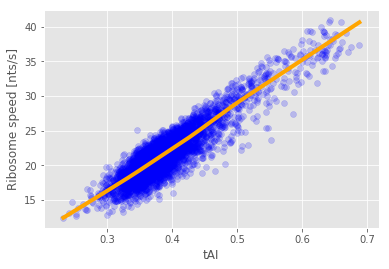

In [10]:
scatter_dicts(tais, ribo_speeds, xaxislabel='tAI', yaxislabel='Ribosome speed [nts/s]', xlog=False, ylog=False)

4475


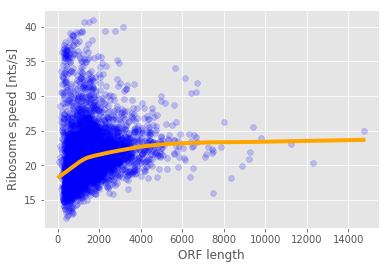

In [11]:
scatter_dicts(orf_lengths, ribo_speeds, xaxislabel='ORF length', yaxislabel='Ribosome speed [nts/s]', 
              xlog=False, ylog=False)

Interestingly some dependency.

We try the univariate model first. (Interesting to see the value of the intercept.)

In [12]:
regression_data = pd.DataFrame([tais, orf_lengths, ribo_speeds]).transpose()
regression_data.columns = ['tAI', 'ORF length', 'Ribosome speed']

Drop values that have data missing:

In [13]:
regression_data = regression_data[~regression_data.isnull().any(axis=1)]
len(regression_data)

4475

In [14]:
regression_data.head()

,tAI,ORF length,Ribosome speed
YAL001C,0.364521,3483.0,21.529576
YAL002W,0.364900,3825.0,19.264669
YAL003W,0.642515,621.0,38.259175
YAL007C,0.443200,648.0,23.798219
YAL008W,0.386541,597.0,20.460496


In [15]:
ntest = 100
regression_x = regression_data['tAI'].reshape((len(regression_data), 1))

# Split the data into training/testing sets
regression_x_train = regression_x[:-ntest]
regression_x_test = regression_x[-ntest:]

# Split the targets into training/testing sets
regression_y_train = regression_data['Ribosome speed'][:-ntest]
regression_y_test = regression_data['Ribosome speed'][-ntest:]

/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


Linear regression:

In [16]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(regression_x_train, regression_y_train)

# Make predictions using the testing set
regression_y_pred = regr.predict(regression_x_test)

# The coefficients
print 'Coefficients: ', regr.coef_[0]
print 'Intercept: ', regr.intercept_

# The mean squared error
print "Mean squared error: %.2f" % mean_squared_error(regression_y_test, regression_y_pred)

# Explained variance score: 1 is perfect prediction
print 'R² score: %.2f' % r2_score(regression_y_test, regression_y_pred)

Coefficients:  61.9829492037
Intercept:  -2.45884201401
Mean squared error: 2.44
R² score: 0.78


This means that the equation is in fact:

$$v = 61.98 \cdot \mathrm{tAI} - 2.46 + \sigma \cdot \varepsilon$$

Plot outputs:

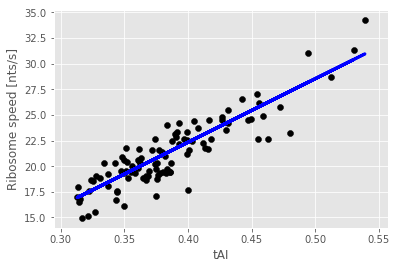

In [17]:
ax = plt.scatter(regression_x_test, regression_y_test,  color='black')
plt.plot(regression_x_test, regression_y_pred, color='blue', linewidth=3)

plt.xlabel("tAI")
plt.ylabel("Ribosome speed [nts/s]")

plt.show()

Plot the residuals to discover any remaining structure:

In [18]:
residuals = regr.predict(regression_x_train) - regression_y_train

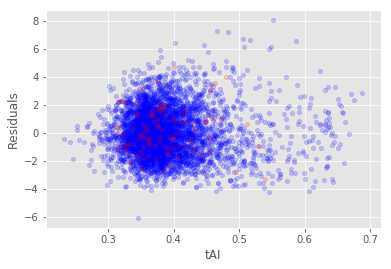

In [19]:
plt.scatter(regression_x_train, residuals, 
            c='b', s=20, alpha=0.2)
plt.scatter(regression_x_test, regr.predict(regression_x_test) - regression_y_test, 
            c='r', s=20, alpha=0.2)
plt.xlabel("tAI")
plt.ylabel("Residuals")

plt.show()

Text(0,0.5,u'Frequency')

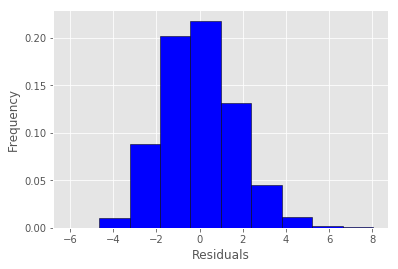

In [20]:
residuals.hist(normed=True, color="b", edgecolor='black')
plt.xlabel("Residuals")
plt.ylabel("Frequency")

In [21]:
residuals.describe()

count    4.375000e+03
mean    -5.684342e-17
std      1.684549e+00
min     -6.068764e+00
25%     -1.191704e+00
50%     -1.253880e-01
75%      1.105381e+00
max      8.041283e+00
Name: Ribosome speed, dtype: float64

This means that the equation is in fact:

$$v = 61.98 \cdot \mathrm{tAI} - 2.46 + 1.68 \cdot \varepsilon$$

where $\varepsilon \sim N (0, 1)$.

<a id='1.2'></a>
### 1.2 Duration post initiation

General form:

$$T = \alpha_L \cdot L^{c_L}$$

where $T$: "toc-tic" duration in seconds

$L$: length of ORF in nts

We try $c_L = 1$ first.

In [22]:
ntest = 1000
these_orf_lengths = {gene: orf_lengths[gene] for gene in gene_tic_toc_dict}
regression_x = np.array([these_orf_lengths[gene] 
                         for gene in gene_tic_toc_dict]).reshape((len(these_orf_lengths), 1))

# Split the data into training/testing sets
regression_x_train = regression_x[:-ntest]
regression_x_test = regression_x[-ntest:]

# Split the targets into training/testing sets
regression_y_train = gene_tic_toc_dict.values()[:-ntest]
regression_y_test = gene_tic_toc_dict.values()[-ntest:]

Linear regression:

In [23]:
# Create linear regression object
regr = linear_model.LinearRegression(fit_intercept=False)

# Train the model using the training sets
regr.fit(regression_x_train, regression_y_train)

# Make predictions using the testing set
regression_y_pred = regr.predict(regression_x_test)

# The coefficients
print 'Coefficients: ', regr.coef_[0]
print 'Intercept: ', regr.intercept_

# The mean squared error
print "Mean squared error: %.2f" % mean_squared_error(regression_y_test, regression_y_pred)

# Explained variance score: 1 is perfect prediction
print 'R² score: %.2f' % r2_score(regression_y_test, regression_y_pred)

Coefficients:  0.045310415791
Intercept:  0.0
Mean squared error: 156.65
R² score: 0.95


The same $R^2$ was obtain when fitting _with_ intercept, so omitting it causes no harm while being more intuitive.

This means that the equation is in fact:

$$T = 0.0453 \cdot L + f(\varepsilon, L)$$

where $\varepsilon \sim N (0, 1)$.

Plot outputs:

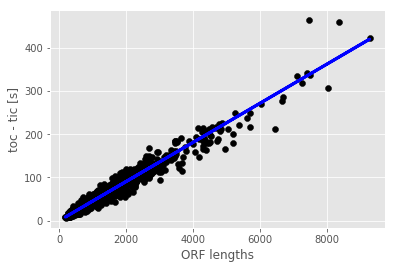

In [24]:
ax = plt.scatter(regression_x_test, regression_y_test,  color='black')
#plt.gca().set_yscale('log')
#plt.gca().set_xscale('log')

plt.plot(regression_x_test, regression_y_pred, color='blue', linewidth=3)

plt.xlabel("ORF lengths")
plt.ylabel("toc - tic [s]")

plt.show()

Plot the residuals to discover any remaining structure:

In [25]:
residuals = regr.predict(regression_x_train) - regression_y_train

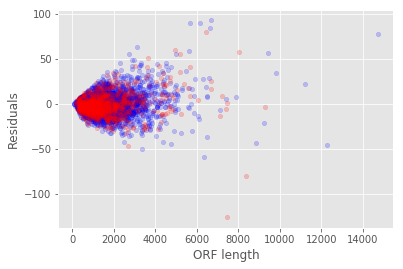

In [26]:
plt.scatter(regression_x_train, residuals, 
            c='b', s=20, alpha=0.2)
plt.scatter(regression_x_test, regr.predict(regression_x_test) - regression_y_test, 
            c='r', s=20, alpha=0.2)
plt.xlabel("ORF length")
plt.ylabel("Residuals")

plt.show()

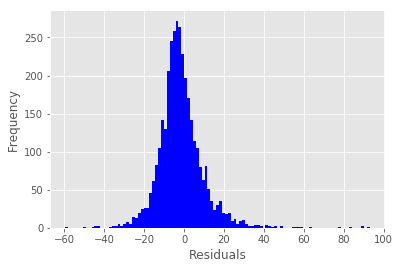

In [27]:
plt.hist(residuals, bins='auto', color="b", edgecolor=None)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

In [28]:
pd.Series(residuals).describe()

count    3475.000000
mean       -1.570916
std        11.335432
min       -59.448697
25%        -7.642934
50%        -2.625198
75%         3.372700
max        92.983846
dtype: float64

This means that the equation is in fact:

$$T = 0.0453 \cdot L + 11.3 \cdot \varepsilon$$

where $\varepsilon \sim N (0, 1)$.

But there might be a size dependency in the residual. We now assume that we can model by

$$T = (0.0453 + \sigma \cdot \varepsilon) \cdot L $$

In [29]:
residuals = (regr.predict(regression_x_train) - regression_y_train) / regr.predict(regression_x_train)

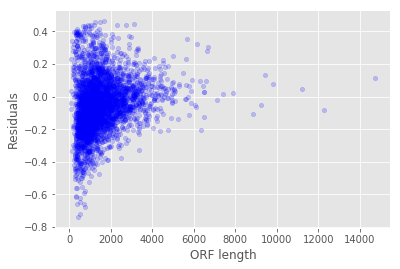

In [30]:
plt.scatter(regression_x_train, residuals, c='b', s=20, alpha=0.2)
#plt.scatter(regression_x_test, (regr.predict(regression_x_test) - regression_y_test) / regression_x_test) #, c='r', s=20, alpha=0.2)
plt.xlabel("ORF length")
plt.ylabel("Residuals")

plt.show()

Looks better, but perhaps still an effect?

Maybe we regress

$$T / L = \alpha_L + \sigma \cdot \varepsilon $$

In [31]:
ntest = 1000
these_orf_lengths = {gene: orf_lengths[gene] for gene in gene_tic_toc_dict}
duration_per_nt = {gene:  gene_tic_toc_dict[gene] / orf_lengths[gene] for gene in gene_tic_toc_dict}

4475


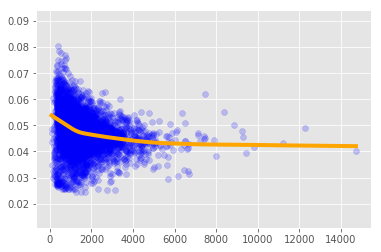

In [32]:
scatter_dicts(orf_lengths, duration_per_nt, xlog=False, ylog=False)

Almost constant.

In [33]:
pd.Series(duration_per_nt.values()).describe()

count    4475.000000
mean        0.047494
std         0.007716
min         0.024454
25%         0.042941
50%         0.047545
75%         0.052371
max         0.080363
dtype: float64

This means we might set

$$T / L = 0.0475 + 0.00772 \cdot \varepsilon $$

TODO: also try a 2d regression

<a id='1.3'></a>
### 1.3 Combination of the previous two models

# TODO

## 2. Model for synthetic protein synthesis rates including initiation probability (TRSL output)

General form:

$$r = f(p, l, m, t)$$

where $p$: initiation probability

$l$: gene length in nts (or codons)

$m$: transcript count

$t$: adaptation index (tAI or cAI)

### 2.1 Linear regression

### 2.2 Additive model

### 2.3 Multiplicative model

### 2.4 Using 1.1 or 1.2 as a submodel

## 3. Model for experimental protein synthesis rates